# SWR

A flexible framework for safe withdrawal rate experiments.

Framework can generalize to
- Any generator of asset returns
- Any asset allocation strategy based on age, returns etc.
- Any utility function to evaluate suitability of strategy (e.g. total spending, certainty equivalent spending)
- Support a survival table 
- Any optimizer to find optimal parameters for a given withdrawal framework and market simulation


In [1]:
import pytest
import numpy as np
import pandas as pd
import pandas_datareader as pdr

from SWRsimulation import SWRsimulation

In [2]:
# load Damodaran data from pickle (via http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/histretSP.html )
RETURN_FILE = 'histretSP'
def load_returns():
    return pd.read_pickle('%s.pickle' % RETURN_FILE)

download_df = load_returns()
return_df = download_df.iloc[:, [0, 3, 12]]
return_df.columns=['stocks', 'bonds', 'cpi']
return_df

stocks     bonds       cpi
Year                              
1928  0.438112  0.032196 -0.011522
1929 -0.082979  0.030179  0.000000
1930 -0.251236  0.005398 -0.026712
1931 -0.438375 -0.156808 -0.089321
1932 -0.086424  0.235896 -0.103014
...        ...       ...       ...
2016  0.117731  0.103651  0.012616
2017  0.216055  0.097239  0.021301
2018 -0.042269 -0.027626  0.024426
2019  0.312117  0.153295  0.022900
2020  0.180139  0.104115  0.012000

[93 rows x 3 columns]

In [3]:
# should adjust CPI to year-ending also but leave it for now
real_return_df = return_df.copy()
# real_return_df.loc[1948:, 'cpi'] = cpi_test['cpi_fred']
# adjust returns for inflation
real_return_df['stocks'] = (1 + real_return_df['stocks']) / (1 + real_return_df['cpi']) - 1
real_return_df['bonds'] = (1 + real_return_df['bonds']) / (1 + real_return_df['cpi']) - 1
real_return_df.drop('cpi', axis=1, inplace=True)
real_return_df

stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns]

In [4]:
# check values per appendix of Bengen paper https://www.retailinvestor.org/pdf/Bengen1.pdf
# nominal return 10% for stocks, 5% for bonds
# inflation 3%
# fixed spending of 4% of orig port
STOCK_RETURN = (1.1 / 1.03) - 1
BOND_RETURN = (1.05 / 1.03) - 1
VARIABLE = 0.0
FIXED = 4.0
NYEARS = 30

returns_df = pd.DataFrame(index=range(1928, 2021), 
                          data={'stocks': STOCK_RETURN, 
                                'bonds': BOND_RETURN})

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': returns_df,
                   'n_ret_years': NYEARS,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED,
                   'variable_pct': VARIABLE},
    'evaluation': {}, # no args, default = number of years to exhaustion
})

print(s)

# a single trial starting in 1928
z = s.simulate_trial(next(s.simulation['trials']))

# match figures in appendix
# example uses nominal vals with 3% inflation, we use real vals
assert z.iloc[0]['before_spend'] * 1.03 == pytest.approx(107.5, 0.000001)
assert z.iloc[0]['spend'] * 1.03 == 4.12, "spend does not match Bengen"
assert z.iloc[0]['end_port'] * 1.03 == pytest.approx(103.38, 0.000001), "ending port does not match Bengen"

z

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
1928  0.067961  0.019417
1929  0.067961  0.019417
1930  0.067961  0.019417
1931  0.067961  0.019417
1932  0.067961  0.019417
...        ...       ...
2016  0.067961  0.019417
2017  0.067961  0.019417
2018  0.067961  0.019417
2019  0.067961  0.019417
2020  0.067961  0.019417

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.historical_trials at 0x7fae12a1ff90>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 4.0, 'variable_pct': 0.0}


start_port  port_return  before_spend  spend    end_port  alloc_0  \
1928  100.000000     0.043689    104.368932    4.0  100.368932      0.5   
1929  100.368932     0.043689    104.753982    4.0  100.753982      0.5   
1930  100.753982     0.043689    105.155855    4.0  101.155855      0.5   
1931  101.155855     0.043689    105.575286    4.0  101.575286      0.5   
1932  101.575286     0.043689    106.013041    4.0  102.013041      0.5   
1933  102.013041     0.043689    106.469922    4.0  102.469922      0.5   
1934  102.469922     0.043689    106.946763    4.0  102.946763      0.5   
1935  102.946763     0.043689    107.444437    4.0  103.444437      0.5   
1936  103.444437     0.043689    107.963854    4.0  103.963854      0.5   
1937  103.963854     0.043689    108.505964    4.0  104.505964      0.5   
1938  104.505964     0.043689    109.071759    4.0  105.071759      0.5   
1939  105.071759     0.043689    109.662273    4.0  105.662273      0.5   
1940  105.662273     0.043689    110.278586    4.0  106.278586      0.5   
1941  106.278586     0.043689    110.921825    4.0  106.921825      0.5   
1942  106.921825     0.043689    111.593167    4.0  107.593167      0.5   
1943  107.593167     0.043689    112.293839    4.0  108.293839      0.5   
1944  108.293839     0.043689    113.025123    4.0  109.025123      0.5   
1945  109.025123     0.043689    113.788357    4.0  109.788357      0.5   
1946  109.788357     0.043689    114.584935    4.0  110.584935      0.5   
1947  110.584935     0.043689    115.416316    4.0  111.416316      0.5   
1948  111.416316     0.043689    116.284019    4.0  112.284019      0.5   
1949  112.284019     0.043689    117.189632    4.0  113.189632      0.5   
1950  113.189632     0.043689    118.134810    4.0  114.134810      0.5   
1951  114.134810     0.043689    119.121282    4.0  115.121282      0.5   
1952  115.121282     0.043689    120.150853    4.0  116.150853      0.5   
1953  116.150853     0.043689    121.225404    4.0  117.225404      0.5   
1954  117.225404     0.043689    122.346903    4.0  118.346903      0.5   
1955  118.346903     0.043689    123.517398    4.0  119.517398      0.5   
1956  119.517398     0.043689    124.739032    4.0  120.739032      0.5   
1957  120.739032     0.043689    126.014039    4.0  122.014039      0.5   

      alloc_1  
1928      0.5  
1929      0.5  
1930      0.5  
1931      0.5  
1932      0.5  
1933      0.5  
1934      0.5  
1935      0.5  
1936      0.5  
1937      0.5  
1938      0.5  
1939      0.5  
1940      0.5  
1941      0.5  
1942      0.5  
1943      0.5  
1944      0.5  
1945      0.5  
1946      0.5  
1947      0.5  
1948      0.5  
1949      0.5  
1950      0.5  
1951      0.5  
1952      0.5  
1953      0.5  
1954      0.5  
1955      0.5  
1956      0.5  
1957      0.5

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.historical_trials at 0x7fae0e9123c0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 4.0, 'variable_pct': 0.0}


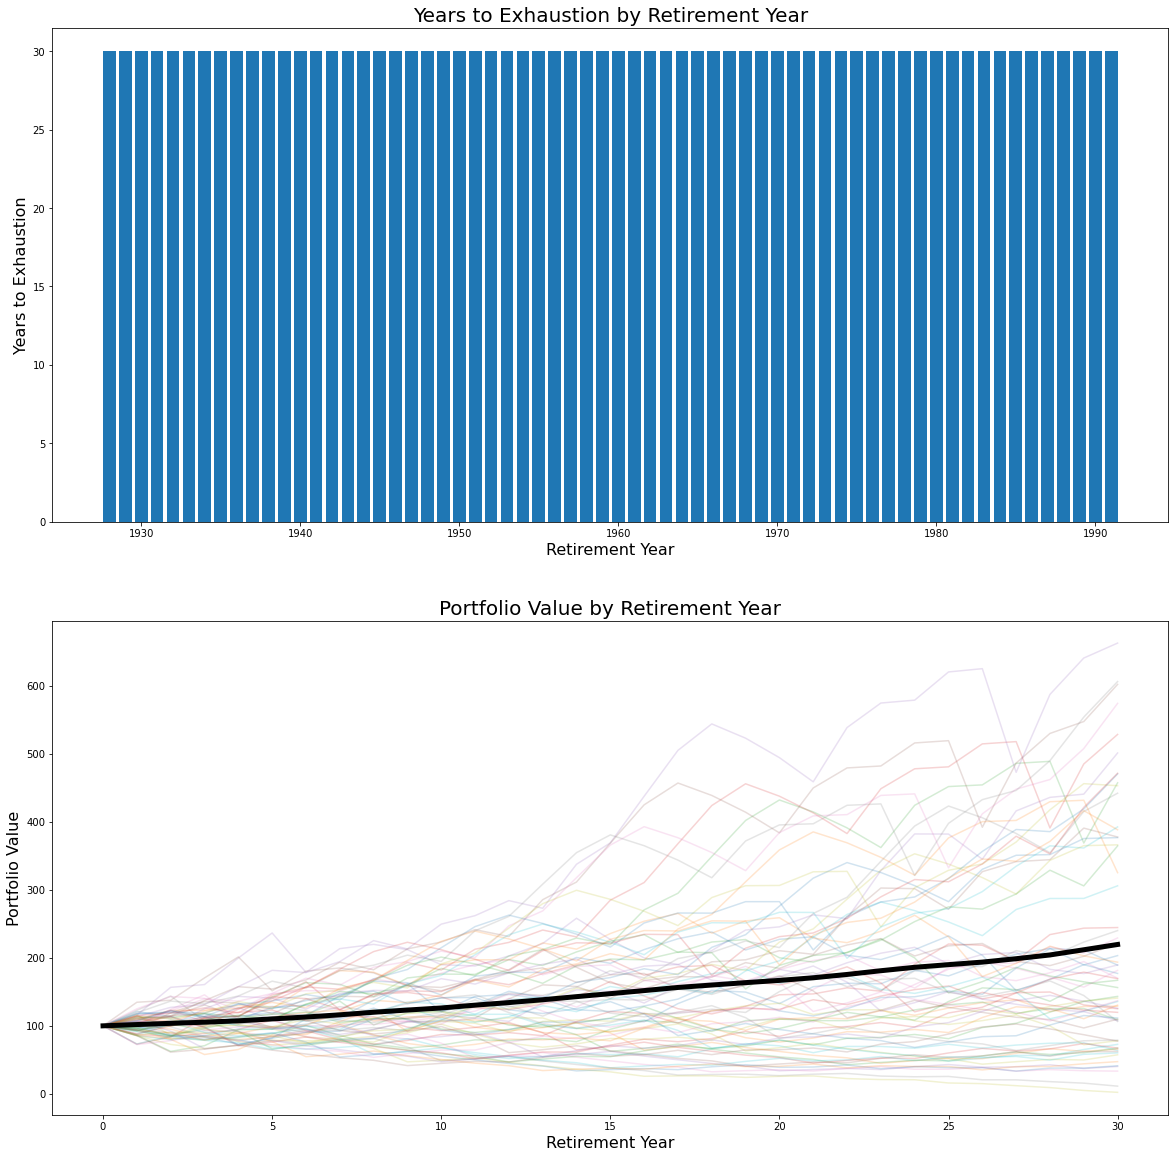

In [5]:
# Bengen 4% rule
VARIABLE = 0.0
FIXED = 4.0
NYEARS = 30

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': NYEARS,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED,
                   'variable_pct': VARIABLE},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'analysis': {}    # haven't defined any analysis options yet
})

print(s)

s.simulate() # returns array of trials (by default all historical retirement periods)
s.analyze()  # chart of latest simulation

In [6]:
# instead of historical, do 1000 montecarlo trials
# for each year of retirement, draw a random year from history to generate performance

Simulation:
{'montecarlo': 1000,
 'montecarlo_replacement': True,
 'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.montecarlo_trials at 0x7fae0cc389e0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 4.0, 'variable_pct': 0.0}
4.90% of portfolios exhausted by final year


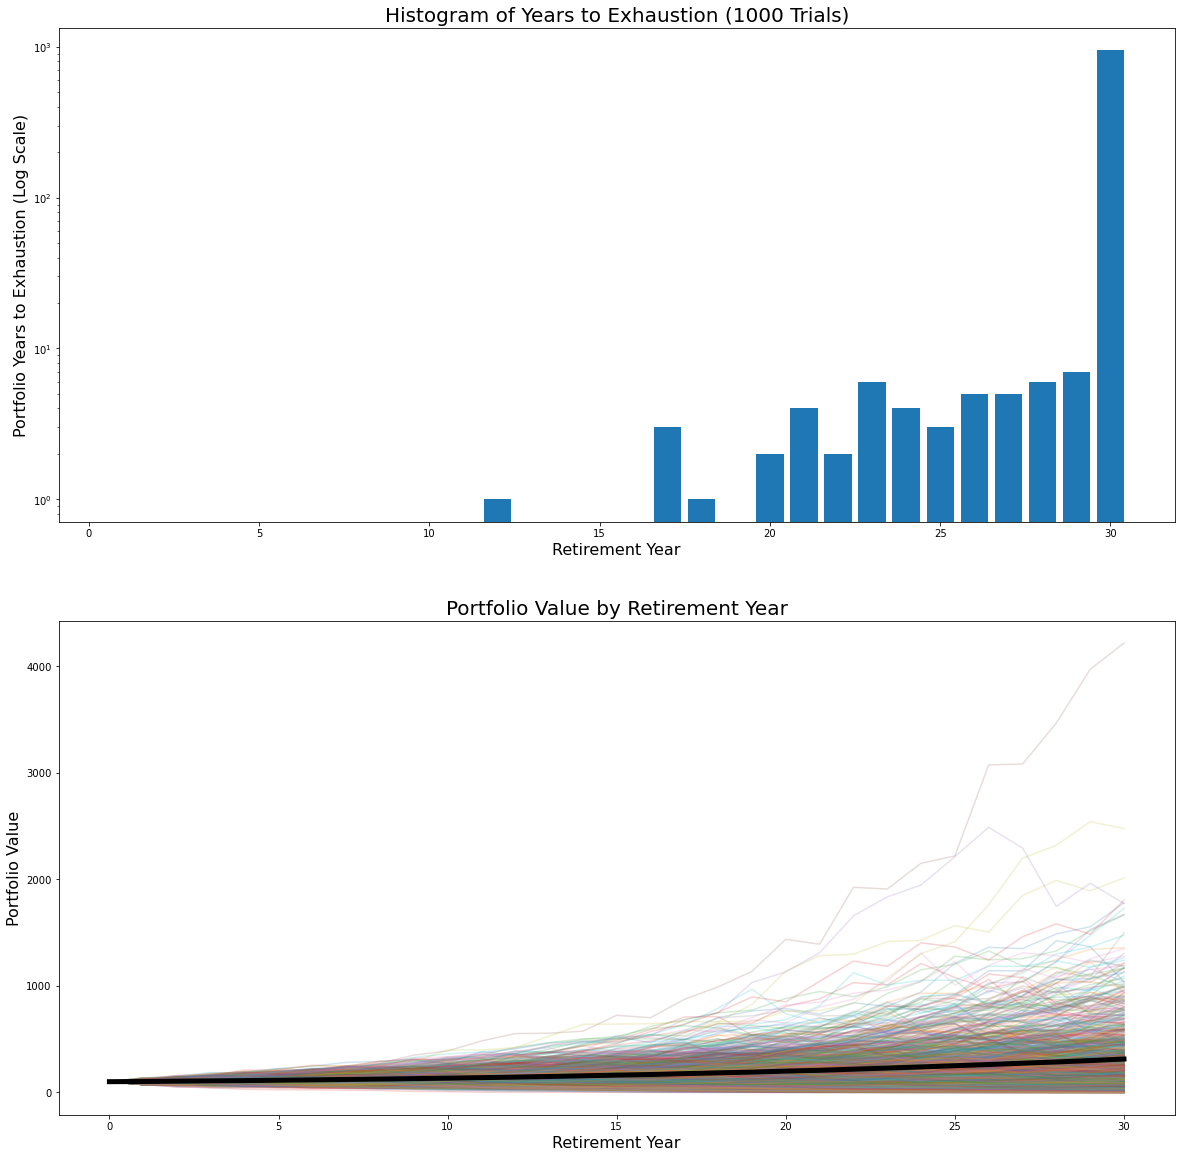

In [7]:
VARIABLE = 0.0
FIXED = 4.0
NYEARS = 30
NTRIALS = 1000

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': real_return_df,
                   'montecarlo': NTRIALS,
                   'montecarlo_replacement': True,
                   'n_ret_years': NYEARS,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED,
                   'variable_pct': VARIABLE},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'analysis': {'histogram': True}    
})

print(s)

# don't keep 1000 historical arrays, just return a single eval for each trial
# eval is the years to exhaustion (30 if never exhausted)
s.simulate()
s.analyze()  # chart of latest simulation

In [8]:
# bengen rule
# suppose portfolio goes up, by induction if 4% is good for 30 years you can safely increase
# if portfolio goes down it's safer to do 4% of new value. if you spend 4% of value instead of fixed you could never go broke since you adjust on the way down
# so 4% seems like a pretty good number in the sense that in the long run you do OK

# I was curious does 4% hold up under monte carlo?

# so 4% historically has been an OK rule


In [9]:
# have github CI run tests automatically

# .analyze() ... run the 2 plots
# analyze_plotly, analyze
# use montecarlo to find a bad example with 4%
# use a fixture to test the eval code, clean up tests

# function to return ce value based on strategy
# ce value of a stream
# ce value of many ce streams
# run bayesian optimizaton, optuna etc.
# ce value of a set of streams over a mortality curve
# try convex optimization
# go through the scikit optimizers and see if there are other global optimizers that might work eg simulated annealing
# accept an arbitrary schedule, utility function, optimizer


# certainty_equivalent_mortality(k_list, mortality_table)
# calculate probability of being alive in years 1...k
# so now you have k lists with associated probabilities
#    certainty_adjust cash flow streams
#    not just full cash flow but range(nyears) cash flows 
#    then certainty adjust over the probability distribution of each sequence of cash flows
    

In [10]:
s.latest_simulation

[{'trial':       start_port  port_return  before_spend  spend    end_port  alloc_0  \
  1928  100.000000     0.249551    124.955061    4.0  120.955061      0.5   
  1985  120.955061     0.231813    148.994051    4.0  144.994051      0.5   
  1952  144.994051     0.088159    157.776561    4.0  153.776561      0.5   
  1929  153.776561    -0.026400    149.716790    4.0  145.716790      0.5   
  2020  145.716790     0.128584    164.453675    4.0  160.453675      0.5   
  1983  160.453675     0.155536    185.410049    4.0  181.410049      0.5   
  1967  181.410049     0.093179    198.313728    4.0  194.313728      0.5   
  2006  194.313728     0.078513    209.569805    4.0  205.569805      0.5   
  2006  205.569805     0.078513    221.709627    4.0  217.709627      0.5   
  1988  217.709627     0.112881    242.284891    4.0  238.284891      0.5   
  1965  238.284891     0.061126    252.850201    4.0  248.850201      0.5   
  2017  248.850201     0.132523    281.828559    4.0  277.828559   

Simulation:
{'montecarlo': 1000,
 'montecarlo_replacement': True,
 'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.montecarlo_trials at 0x7fae0cea7f20>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 4.0, 'variable_pct': 0.0}
5.90% of portfolios exhausted by final year


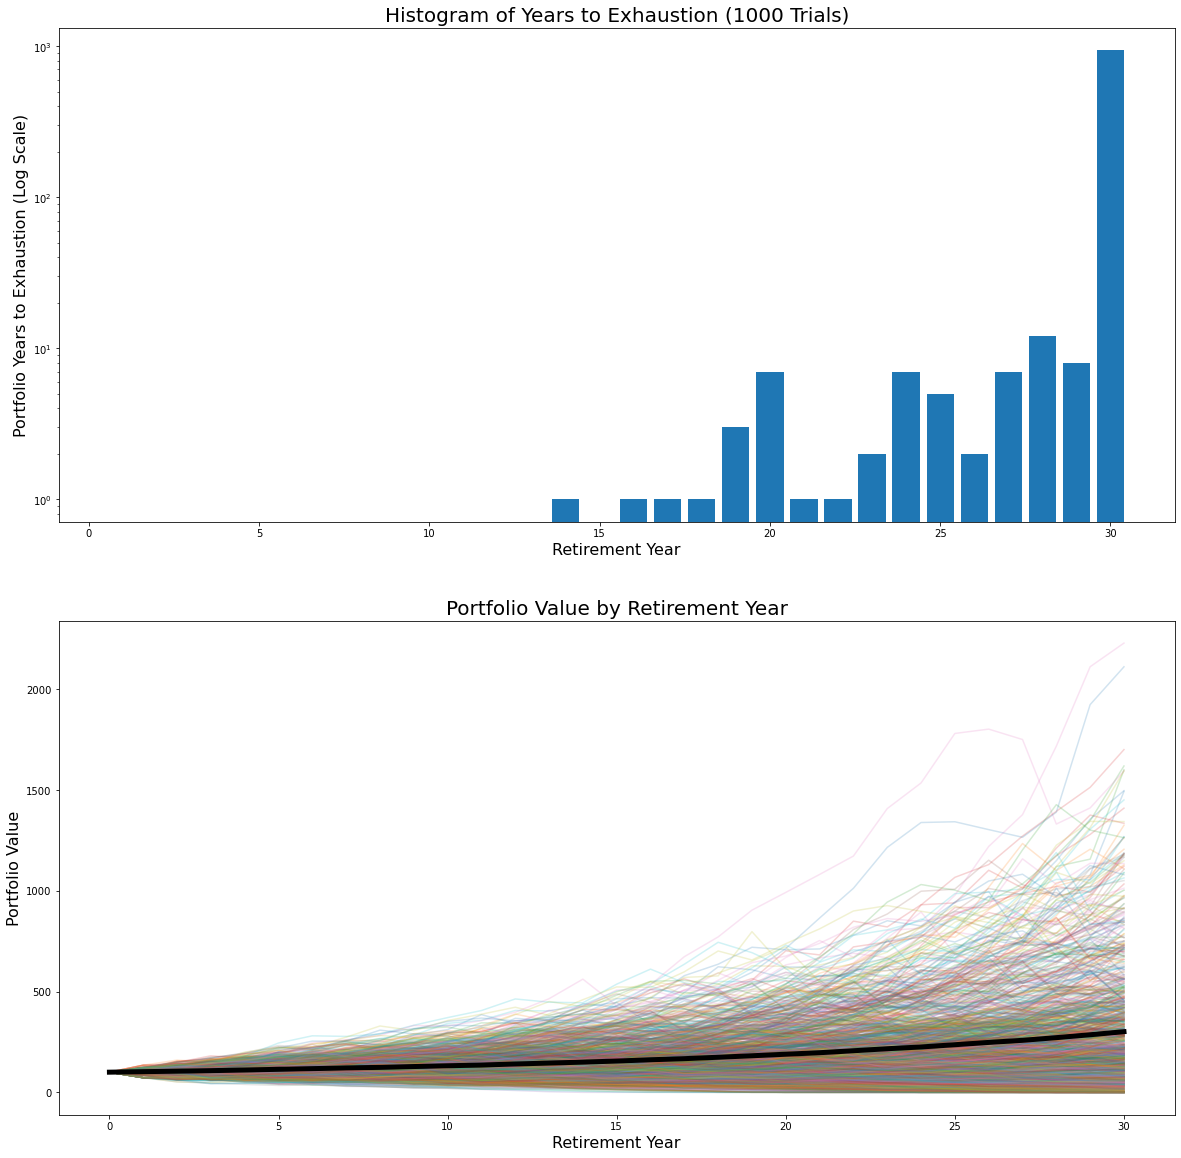

In [11]:
VARIABLE = 0.0
FIXED = 4.0
NYEARS = 30
NTRIALS = 1000

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': real_return_df,
                   'montecarlo': NTRIALS,
                   'montecarlo_replacement': True,
                   'n_ret_years': NYEARS,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED,
                   'variable_pct': VARIABLE},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'analysis': {'histogram': True}    
})

print(s)

s.simulate()
s.analyze()  # chart of latest simulation

In [19]:
FIXED_SPEND = 2
VARIABLE_SPEND = 2
ALLOC_STOCKS = 0.6
ALLOC_BONDS = 0.5
N_RET_YEARS = 30

def ce_experiment_factory(gamma):
    def ce_experiment(fixed_spend, variable_spend, alloc_stocks, n_ret_years):

        alloc_bonds = 1.0 - alloc_stocks

        s = SWRsimulation.SWRsimulation({
            'simulation': {'returns_df': real_return_df,
                           'n_ret_years': n_ret_years,
                          },
            'allocation': {'asset_weights': np.array([alloc_stocks, alloc_bonds])}, 
            'withdrawal': {'fixed_pct': fixed_spend,
                           'variable_pct': variable_spend},
            'evaluation': {},
            'analysis': {}    
        })
        s.simulate()
        return SWRsimulation.crra_ce(np.array([z['ce_spend'] for z in s.latest_simulation]), gamma)
    return ce_experiment

ce_experiment_factory(1)(FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS, N_RET_YEARS)



9519.256017841693

In [ ]:
import optuna

def objective_factory(gamma):
    def objective(trial):
        alloc_stocks = trial.suggest_uniform('alloc_stocks', 0, 1)
        fixed_spend = trial.suggest_uniform('fixed_spend', 0, 5)
        variable_spend = trial.suggest_uniform('variable_spend', 0, 10)
        n_ret_years = 30

        return -ce_experiment_factory(gamma)(fixed_spend, variable_spend, alloc_stocks, n_ret_years)
    return objective

study_params = []
study_values = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]
for gamma in study_gammas:
    study = optuna.create_study()
    study.optimize(objective_factory(gamma), n_trials=10000)
    study_params.append(study.best_params)
    study_values.append(study.best_value)
    
    

[I 2021-02-03 23:51:58,949] A new study created in memory with name: no-name-87d2f34a-662a-4425-937d-790fdc7ef5b1
[I 2021-02-03 23:51:59,060] Trial 0 finished with value: -9000.442211236023 and parameters: {'alloc_stocks': 0.2876970838679572, 'fixed_spend': 2.1037069382275346, 'variable_spend': 2.231849243304811}. Best is trial 0 with value: -9000.442211236023.
[I 2021-02-03 23:51:59,161] Trial 1 finished with value: -11368.263238347567 and parameters: {'alloc_stocks': 0.4900824754579661, 'fixed_spend': 1.1711811469780586, 'variable_spend': 8.084715042924268}. Best is trial 1 with value: -11368.263238347567.
[I 2021-02-03 23:51:59,263] Trial 2 finished with value: -11075.797898356957 and parameters: {'alloc_stocks': 0.4824289160094196, 'fixed_spend': 1.5759556760478854, 'variable_spend': 8.618554605207919}. Best is trial 1 with value: -11368.263238347567.
[I 2021-02-03 23:51:59,364] Trial 3 finished with value: -12208.902254363358 and parameters: {'alloc_stocks': 0.5962792775652781, 'f

[I 2021-02-03 23:52:02,362] Trial 31 finished with value: -15167.585410138849 and parameters: {'alloc_stocks': 0.9893908210311392, 'fixed_spend': 0.8365654128276216, 'variable_spend': 6.521692164946884}. Best is trial 13 with value: -15468.483057341877.
[I 2021-02-03 23:52:02,471] Trial 32 finished with value: -14935.582422314317 and parameters: {'alloc_stocks': 0.9962769535576783, 'fixed_spend': 1.1243887958831678, 'variable_spend': 7.2573670609917595}. Best is trial 13 with value: -15468.483057341877.
[I 2021-02-03 23:52:02,577] Trial 33 finished with value: -13618.556205376044 and parameters: {'alloc_stocks': 0.9204747182283017, 'fixed_spend': 1.883191887237444, 'variable_spend': 8.018108107630326}. Best is trial 13 with value: -15468.483057341877.
[I 2021-02-03 23:52:02,683] Trial 34 finished with value: -13509.44889153172 and parameters: {'alloc_stocks': 0.8947367655053295, 'fixed_spend': 1.4334776221337684, 'variable_spend': 8.482827880239771}. Best is trial 13 with value: -15468

[I 2021-02-03 23:52:05,823] Trial 62 finished with value: -15200.49118838544 and parameters: {'alloc_stocks': 0.9979167580912152, 'fixed_spend': 0.7220647147193667, 'variable_spend': 5.051954421093434}. Best is trial 61 with value: -15492.912065248775.
[I 2021-02-03 23:52:05,930] Trial 63 finished with value: -15262.318430030919 and parameters: {'alloc_stocks': 0.9996683215524687, 'fixed_spend': 0.30402469592297465, 'variable_spend': 5.061242398434225}. Best is trial 61 with value: -15492.912065248775.
[I 2021-02-03 23:52:06,039] Trial 64 finished with value: -13934.729517880238 and parameters: {'alloc_stocks': 0.8937122375685379, 'fixed_spend': 0.015064715273046203, 'variable_spend': 4.529479049925967}. Best is trial 61 with value: -15492.912065248775.
[I 2021-02-03 23:52:06,147] Trial 65 finished with value: -14629.103959581847 and parameters: {'alloc_stocks': 0.9368064948154986, 'fixed_spend': 0.31663911291604746, 'variable_spend': 5.018062380683263}. Best is trial 61 with value: -1

[I 2021-02-03 23:52:09,155] Trial 93 finished with value: -15262.691800907702 and parameters: {'alloc_stocks': 0.9976116984914722, 'fixed_spend': 0.6758960858728609, 'variable_spend': 6.674703103579125}. Best is trial 61 with value: -15492.912065248775.
[I 2021-02-03 23:52:09,262] Trial 94 finished with value: -14615.96370712109 and parameters: {'alloc_stocks': 0.9523551295263878, 'fixed_spend': 1.453842910804005, 'variable_spend': 6.788030130667196}. Best is trial 61 with value: -15492.912065248775.
[I 2021-02-03 23:52:09,370] Trial 95 finished with value: -14137.162340222847 and parameters: {'alloc_stocks': 0.8805254207047368, 'fixed_spend': 0.6477577851849194, 'variable_spend': 7.24699131395086}. Best is trial 61 with value: -15492.912065248775.
[I 2021-02-03 23:52:09,478] Trial 96 finished with value: -15095.958370800354 and parameters: {'alloc_stocks': 0.977958202550082, 'fixed_spend': 0.9683183639005457, 'variable_spend': 5.852132064455769}. Best is trial 61 with value: -15492.91

[I 2021-02-03 23:52:12,491] Trial 124 finished with value: -15264.110541949058 and parameters: {'alloc_stocks': 0.9769288613601621, 'fixed_spend': 0.15343390984216598, 'variable_spend': 6.205543112863679}. Best is trial 61 with value: -15492.912065248775.
[I 2021-02-03 23:52:12,599] Trial 125 finished with value: -14926.639762374412 and parameters: {'alloc_stocks': 0.9459022857613472, 'fixed_spend': 0.2678423292464555, 'variable_spend': 5.845049817198906}. Best is trial 61 with value: -15492.912065248775.
[I 2021-02-03 23:52:12,706] Trial 126 finished with value: -15375.139231902567 and parameters: {'alloc_stocks': 0.9990521787634893, 'fixed_spend': 0.3904267159266097, 'variable_spend': 5.517274667429383}. Best is trial 61 with value: -15492.912065248775.
[I 2021-02-03 23:52:12,814] Trial 127 finished with value: -13690.98116719068 and parameters: {'alloc_stocks': 0.8961091678902231, 'fixed_spend': 3.0170487500697107, 'variable_spend': 6.002663289194705}. Best is trial 61 with value: -

[I 2021-02-03 23:52:15,834] Trial 155 finished with value: -15480.073004779608 and parameters: {'alloc_stocks': 0.9984536463892351, 'fixed_spend': 0.10611682548967605, 'variable_spend': 5.929038032720663}. Best is trial 136 with value: -15516.58930631208.
[I 2021-02-03 23:52:15,941] Trial 156 finished with value: -15520.406346928707 and parameters: {'alloc_stocks': 0.9998666162663141, 'fixed_spend': 0.0014478105471008394, 'variable_spend': 6.468369864873945}. Best is trial 156 with value: -15520.406346928707.
[I 2021-02-03 23:52:16,049] Trial 157 finished with value: -14911.973516298705 and parameters: {'alloc_stocks': 0.9389053615013249, 'fixed_spend': 0.06229930779042143, 'variable_spend': 6.478643721066349}. Best is trial 156 with value: -15520.406346928707.
[I 2021-02-03 23:52:16,157] Trial 158 finished with value: -15290.705270900828 and parameters: {'alloc_stocks': 0.9773416278470097, 'fixed_spend': 0.05598378719700667, 'variable_spend': 6.30079392151306}. Best is trial 156 with 

[I 2021-02-03 23:52:19,184] Trial 186 finished with value: -15491.521072549696 and parameters: {'alloc_stocks': 0.9980755173886235, 'fixed_spend': 0.002127257878799125, 'variable_spend': 6.5866893543751805}. Best is trial 163 with value: -15527.373243543538.
[I 2021-02-03 23:52:19,293] Trial 187 finished with value: -15310.19382488462 and parameters: {'alloc_stocks': 0.9804779798711393, 'fixed_spend': 0.01100281530626501, 'variable_spend': 6.636996393184099}. Best is trial 163 with value: -15527.373243543538.
[I 2021-02-03 23:52:19,402] Trial 188 finished with value: -15444.028708484662 and parameters: {'alloc_stocks': 0.9981475875099498, 'fixed_spend': 0.002033488437522324, 'variable_spend': 6.915556891810686}. Best is trial 163 with value: -15527.373243543538.
[I 2021-02-03 23:52:19,511] Trial 189 finished with value: -15474.909003666366 and parameters: {'alloc_stocks': 0.9989895719939786, 'fixed_spend': 0.1151395097674527, 'variable_spend': 6.500383579596766}. Best is trial 163 with

[I 2021-02-03 23:52:22,538] Trial 217 finished with value: -15467.003936959829 and parameters: {'alloc_stocks': 0.9990971861950491, 'fixed_spend': 0.21511798868818618, 'variable_spend': 6.123232023214437}. Best is trial 163 with value: -15527.373243543538.
[I 2021-02-03 23:52:22,646] Trial 218 finished with value: -15391.364970115537 and parameters: {'alloc_stocks': 0.9999126429530718, 'fixed_spend': 0.30257942561156026, 'variable_spend': 6.745102878637631}. Best is trial 163 with value: -15527.373243543538.
[I 2021-02-03 23:52:22,754] Trial 219 finished with value: -15295.055832634735 and parameters: {'alloc_stocks': 0.9792445033185322, 'fixed_spend': 0.0984568362845929, 'variable_spend': 6.3802715229011415}. Best is trial 163 with value: -15527.373243543538.
[I 2021-02-03 23:52:22,861] Trial 220 finished with value: -15027.044943036384 and parameters: {'alloc_stocks': 0.9492479838901953, 'fixed_spend': 0.007263422522274701, 'variable_spend': 6.137338426627942}. Best is trial 163 with

[I 2021-02-03 23:52:26,024] Trial 248 finished with value: -15484.92173748126 and parameters: {'alloc_stocks': 0.9993596634597938, 'fixed_spend': 0.009648357855600878, 'variable_spend': 5.716556098019413}. Best is trial 163 with value: -15527.373243543538.
[I 2021-02-03 23:52:26,132] Trial 249 finished with value: -15335.932184582627 and parameters: {'alloc_stocks': 0.982620777439097, 'fixed_spend': 0.006669713666347374, 'variable_spend': 5.86313755641905}. Best is trial 163 with value: -15527.373243543538.
[I 2021-02-03 23:52:26,240] Trial 250 finished with value: -14855.040836011161 and parameters: {'alloc_stocks': 0.9442308762784605, 'fixed_spend': 0.09661028979591997, 'variable_spend': 5.421520068132864}. Best is trial 163 with value: -15527.373243543538.
[I 2021-02-03 23:52:26,349] Trial 251 finished with value: -15482.593028825499 and parameters: {'alloc_stocks': 0.9995923515601632, 'fixed_spend': 0.15538714952690552, 'variable_spend': 6.321086997205934}. Best is trial 163 with v

[I 2021-02-03 23:52:29,433] Trial 279 finished with value: -15032.554327692858 and parameters: {'alloc_stocks': 0.9668607632292772, 'fixed_spend': 0.32646588351856287, 'variable_spend': 6.963533156557168}. Best is trial 271 with value: -15530.468830332527.
[I 2021-02-03 23:52:29,544] Trial 280 finished with value: -14834.170996354645 and parameters: {'alloc_stocks': 0.9841507756142946, 'fixed_spend': 2.004186086552223, 'variable_spend': 6.092587480747467}. Best is trial 271 with value: -15530.468830332527.
[I 2021-02-03 23:52:29,653] Trial 281 finished with value: -15485.676860649399 and parameters: {'alloc_stocks': 0.9990224805430377, 'fixed_spend': 0.09173533408097281, 'variable_spend': 6.462126715924209}. Best is trial 271 with value: -15530.468830332527.
[I 2021-02-03 23:52:29,763] Trial 282 finished with value: -14953.014288215616 and parameters: {'alloc_stocks': 0.9462510385912765, 'fixed_spend': 0.20740681949202816, 'variable_spend': 6.008922323622897}. Best is trial 271 with va

[I 2021-02-03 23:52:32,836] Trial 310 finished with value: -15478.871599559065 and parameters: {'alloc_stocks': 0.9997085261769993, 'fixed_spend': 0.004654491971598257, 'variable_spend': 5.656222153825378}. Best is trial 271 with value: -15530.468830332527.
[I 2021-02-03 23:52:32,945] Trial 311 finished with value: -15160.670058272994 and parameters: {'alloc_stocks': 0.9684559539667179, 'fixed_spend': 0.002317806173531306, 'variable_spend': 6.896933728996322}. Best is trial 271 with value: -15530.468830332527.
[I 2021-02-03 23:52:33,054] Trial 312 finished with value: -12089.449602251316 and parameters: {'alloc_stocks': 0.7989373839205929, 'fixed_spend': 4.83866911508316, 'variable_spend': 5.964813963021868}. Best is trial 271 with value: -15530.468830332527.
[I 2021-02-03 23:52:33,164] Trial 313 finished with value: -14804.413785305287 and parameters: {'alloc_stocks': 0.9255034376334129, 'fixed_spend': 0.000846396704728118, 'variable_spend': 6.285982872963834}. Best is trial 271 with 

[I 2021-02-03 23:52:36,289] Trial 341 finished with value: -15137.770152975305 and parameters: {'alloc_stocks': 0.9628007727490433, 'fixed_spend': 0.0004184103602853603, 'variable_spend': 5.851082269415772}. Best is trial 326 with value: -15530.646260425514.
[I 2021-02-03 23:52:36,400] Trial 342 finished with value: -15449.615664801117 and parameters: {'alloc_stocks': 0.9993099251739928, 'fixed_spend': 0.17954110434929763, 'variable_spend': 6.579936367715519}. Best is trial 326 with value: -15530.646260425514.
[I 2021-02-03 23:52:36,512] Trial 343 finished with value: -12238.10767967581 and parameters: {'alloc_stocks': 0.6165318543580223, 'fixed_spend': 0.09697733558230684, 'variable_spend': 6.149040371742968}. Best is trial 326 with value: -15530.646260425514.
[I 2021-02-03 23:52:36,623] Trial 344 finished with value: -15264.585240995777 and parameters: {'alloc_stocks': 0.9807964218551795, 'fixed_spend': 0.2534230116290434, 'variable_spend': 6.432238816752391}. Best is trial 326 with 

[I 2021-02-03 23:52:39,713] Trial 372 finished with value: -14819.935357417944 and parameters: {'alloc_stocks': 0.9282057691344874, 'fixed_spend': 0.006222672992066831, 'variable_spend': 6.046654695615986}. Best is trial 326 with value: -15530.646260425514.
[I 2021-02-03 23:52:39,824] Trial 373 finished with value: -15146.21866657462 and parameters: {'alloc_stocks': 0.9656849216928839, 'fixed_spend': 0.19129548323063925, 'variable_spend': 6.128941296711377}. Best is trial 326 with value: -15530.646260425514.
[I 2021-02-03 23:52:39,934] Trial 374 finished with value: -14965.169331481631 and parameters: {'alloc_stocks': 0.9459627869663777, 'fixed_spend': 0.08511907951410115, 'variable_spend': 6.580222977756858}. Best is trial 326 with value: -15530.646260425514.
[I 2021-02-03 23:52:40,044] Trial 375 finished with value: -15294.469907013801 and parameters: {'alloc_stocks': 0.9831100693875678, 'fixed_spend': 0.2328856649992955, 'variable_spend': 5.866493730784895}. Best is trial 326 with v

[I 2021-02-03 23:52:43,276] Trial 403 finished with value: -14974.549500900277 and parameters: {'alloc_stocks': 0.9471819377623298, 'fixed_spend': 0.16942721976612132, 'variable_spend': 6.199112872662332}. Best is trial 326 with value: -15530.646260425514.
[I 2021-02-03 23:52:43,387] Trial 404 finished with value: -14602.959440220704 and parameters: {'alloc_stocks': 0.9043095839150603, 'fixed_spend': 0.005188619605037772, 'variable_spend': 6.187345995153207}. Best is trial 326 with value: -15530.646260425514.
[I 2021-02-03 23:52:43,497] Trial 405 finished with value: -15522.367776672034 and parameters: {'alloc_stocks': 0.9998713380662437, 'fixed_spend': 0.003419065777693686, 'variable_spend': 6.433428576849363}. Best is trial 326 with value: -15530.646260425514.
[I 2021-02-03 23:52:43,608] Trial 406 finished with value: -15450.612780582695 and parameters: {'alloc_stocks': 0.9996112039919209, 'fixed_spend': 0.09859863615665215, 'variable_spend': 6.773431903763639}. Best is trial 326 wit

[I 2021-02-03 23:52:46,695] Trial 434 finished with value: -15210.108988403168 and parameters: {'alloc_stocks': 0.9677710225208391, 'fixed_spend': 0.00027009030141258127, 'variable_spend': 6.334278802916066}. Best is trial 326 with value: -15530.646260425514.
[I 2021-02-03 23:52:46,804] Trial 435 finished with value: -14833.959548167933 and parameters: {'alloc_stocks': 0.9997126622076078, 'fixed_spend': 0.0018216718530417435, 'variable_spend': 8.767449173752695}. Best is trial 326 with value: -15530.646260425514.
[I 2021-02-03 23:52:46,914] Trial 436 finished with value: -15303.39023882735 and parameters: {'alloc_stocks': 0.983310739961151, 'fixed_spend': 0.10661150692702034, 'variable_spend': 6.682985221283399}. Best is trial 326 with value: -15530.646260425514.
[I 2021-02-03 23:52:47,024] Trial 437 finished with value: -15000.083650205546 and parameters: {'alloc_stocks': 0.9514568702141478, 'fixed_spend': 0.22906464789572092, 'variable_spend': 6.299022952520116}. Best is trial 326 wi

[I 2021-02-03 23:52:50,102] Trial 465 finished with value: -15452.415142644903 and parameters: {'alloc_stocks': 0.9990938098971587, 'fixed_spend': 0.2686944280502377, 'variable_spend': 6.174451140101213}. Best is trial 326 with value: -15530.646260425514.
[I 2021-02-03 23:52:50,212] Trial 466 finished with value: -15266.050971069722 and parameters: {'alloc_stocks': 0.9781357480482703, 'fixed_spend': 0.1650167140087174, 'variable_spend': 6.389144444936295}. Best is trial 326 with value: -15530.646260425514.
[I 2021-02-03 23:52:50,322] Trial 467 finished with value: -15520.49955318477 and parameters: {'alloc_stocks': 0.9990644608708914, 'fixed_spend': 0.0025115783384007688, 'variable_spend': 6.096799059124831}. Best is trial 326 with value: -15530.646260425514.
[I 2021-02-03 23:52:50,432] Trial 468 finished with value: -15333.197039727846 and parameters: {'alloc_stocks': 0.9812308010973905, 'fixed_spend': 0.0012839812794904028, 'variable_spend': 5.964435511391144}. Best is trial 326 with

[I 2021-02-03 23:52:53,519] Trial 496 finished with value: -15468.151758197304 and parameters: {'alloc_stocks': 0.9999698325223217, 'fixed_spend': 0.21650836063215295, 'variable_spend': 6.3368336803955945}. Best is trial 326 with value: -15530.646260425514.
[I 2021-02-03 23:52:53,629] Trial 497 finished with value: -15307.83841745685 and parameters: {'alloc_stocks': 0.9816535936723063, 'fixed_spend': 0.08793492740577201, 'variable_spend': 6.5555812476289566}. Best is trial 326 with value: -15530.646260425514.
[I 2021-02-03 23:52:53,739] Trial 498 finished with value: -14419.729857571641 and parameters: {'alloc_stocks': 0.8892964355044987, 'fixed_spend': 0.2905119731067894, 'variable_spend': 6.124814701709503}. Best is trial 326 with value: -15530.646260425514.
[I 2021-02-03 23:52:53,849] Trial 499 finished with value: -15436.375696866031 and parameters: {'alloc_stocks': 0.9991053682735556, 'fixed_spend': 0.1473895312207005, 'variable_spend': 5.607837285878664}. Best is trial 326 with v

[I 2021-02-03 23:52:56,939] Trial 527 finished with value: -15267.397614236366 and parameters: {'alloc_stocks': 0.9796972504202103, 'fixed_spend': 0.2493791146390941, 'variable_spend': 6.049072539820706}. Best is trial 326 with value: -15530.646260425514.
[I 2021-02-03 23:52:57,049] Trial 528 finished with value: -14699.097327510888 and parameters: {'alloc_stocks': 0.9550893311763556, 'fixed_spend': 1.6976875411676902, 'variable_spend': 6.2383716074644555}. Best is trial 326 with value: -15530.646260425514.
[I 2021-02-03 23:52:57,159] Trial 529 finished with value: -14597.705283167823 and parameters: {'alloc_stocks': 0.9990864086184285, 'fixed_spend': 3.2185728897596206, 'variable_spend': 4.733545154926979}. Best is trial 326 with value: -15530.646260425514.
[I 2021-02-03 23:52:57,272] Trial 530 finished with value: -15325.225704064962 and parameters: {'alloc_stocks': 0.9809556217936527, 'fixed_spend': 0.0012732178134931835, 'variable_spend': 6.563542300962235}. Best is trial 326 with 

In [31]:
study_params

[{'alloc_stocks': 0.9956427074639996,
  'fixed_spend': 0.028540678620604776,
  'variable_spend': 5.831569243713403},
 {'alloc_stocks': 0.9992175395790837,
  'fixed_spend': 0.23774472268159075,
  'variable_spend': 5.994965831024759},
 {'alloc_stocks': 0.7530623982984634,
  'fixed_spend': 1.9761235395967707,
  'variable_spend': 5.121602011793098}]

In [40]:
import optuna

def objective(trial):
    
    
    return 

study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params  # E.g. {'x': 2.002108042}


[I 2021-02-03 22:17:41,052] A new study created in memory with name: no-name-e1a23db3-40f7-4fad-9646-458cd35c9c2d
[W 2021-02-03 22:17:41,054] Trial 0 failed because of the following error: AttributeError("'Trial' object has no attribute 'suggest'")
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.8/site-packages/optuna/_optimize.py", line 189, in _run_trial
    value = func(trial)
  File "<ipython-input-40-d4d49843ab2c>", line 5, in objective
    alloc_stocks = trial.suggest.uniform('alloc_stocks', 0, 1)
AttributeError: 'Trial' object has no attribute 'suggest'


AttributeError: 'Trial' object has no attribute 'suggest'

In [13]:
# TODO: analyze should compute ce spend over history
# write a function to take 4 parameters, fixed variable stocks bonds and return CE over history
# run optimizer on function



[119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 0.0,
 0.0,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 119.99999999999991,
 0.0,
 119.99999999999991,
 119.99999999999991,
 119.99999999999